In [1]:
import grpc
import cv2
from scipy.io import savemat
from IPython.display import display
from PIL import Image
from IPython.display import display
from io import BytesIO

import sys
sys.path.append("../protos")
import pipeline_pb2 as yolo_pb2
import pipeline_pb2_grpc as yolo_pb2_grpc
from aux import wrap_value, unwrap_value
import json

### If grpc versions are different compile yolo_pb2 and yolo_pb2_grpc 

python -m grpc_tools.protoc -I. -I../protos --python_out=. --grpc_python_out=. yolo.proto

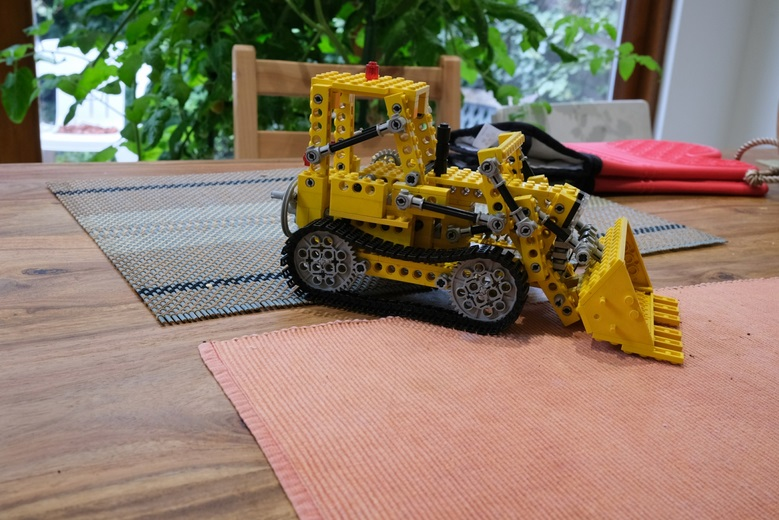

In [2]:
with open("../../vggt/test/images/00.jpg", "rb") as f:
    img_bytes = f.read()
image = Image.open(BytesIO(img_bytes))
display(image)



In [81]:
config_json = {
    "aispgradio": {
        "command": "single",
    }
}

request = yolo_pb2.Envelope(data={"images":wrap_value([img_bytes])},
                            config_json = json.dumps(config_json))

#Para imagens muito grandes buffer grande
target='localhost:1234'
channel_opt = [('grpc.max_send_message_length', -1), ('grpc.max_receive_message_length', -1)]
channel=grpc.insecure_channel(target,options=channel_opt)
estimator_stub = yolo_pb2_grpc.PipelineServiceStub(channel)



### Tracking 

In [103]:
response = estimator_stub.AllProcessing(request)

In [24]:
# Read image and encode as bytes
img = cv2.imread("../../Images/eiffel.png")
_,img_encoded = cv2.imencode('.jpg', img)
img_bytes = img_encoded.tobytes()

channel = grpc.insecure_channel('localhost:8061')
stub = yolo_pb2_grpc.YOLOserviceStub(channel)
comms=json.dumps([{"reset":1},{"conf":0.2}])
response = stub.Track(yolo_pb2.YOLOTrackRequest(image=img_bytes,track_config_json=comms))
#channel.close()


### One argument only

In [23]:
# Read image and encode as bytes
img = cv2.imread("../../Images/eiffel.png")
_,img_encoded = cv2.imencode('.jpg', img)
img_bytes = img_encoded.tobytes()
channel = grpc.insecure_channel('localhost:8061')
stub = yolo_pb2_grpc.YOLOserviceStub(channel)
response = stub.Track(yolo_pb2.YOLOTrackRequest(image=img_bytes))
#channel.close()


In [ ]:
import ultralytics
import cv2

arg={"source":"../../Images/eiffel.png","conf":0.2}
m=ultralytics.YOLO("yolo11n.pt")
r=m(**arg)



image 1/1 /workspaces/boxes/yologpt/test/../../Images/eiffel.png: 384x640 4 persons, 58.4ms
Speed: 1.1ms preprocess, 58.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


In [105]:
import grpc
from grpc_reflection.v1alpha import reflection_pb2, reflection_pb2_grpc

def list_services_and_methods(target="localhost:8061"):
    # Connect to the gRPC server
    channel = grpc.insecure_channel(target)
    stub = reflection_pb2_grpc.ServerReflectionStub(channel)

    # Ask the server to list services
    request = reflection_pb2.ServerReflectionRequest(
        list_services="",
    )

    response_stream = stub.ServerReflectionInfo(iter([request]))
    for response in response_stream:
        service_response = response.list_services_response
        for service in service_response.service:
            service_name = service.name
            print(f"Service: {service_name}")

            # Now describe each service
            describe_req = reflection_pb2.ServerReflectionRequest(
                file_containing_symbol=service_name
            )

            describe_stream = stub.ServerReflectionInfo(iter([describe_req]))
            for desc_response in describe_stream:
                file_desc = desc_response.file_descriptor_response
                for proto_bytes in file_desc.file_descriptor_proto:
                    from google.protobuf.descriptor_pb2 import FileDescriptorProto
                    fd = FileDescriptorProto.FromString(proto_bytes)

                    for srv in fd.service:
                        if srv.name in service_name:
                            for method in srv.method:
                                print(f"  - {method.name} (input={method.input_type}, output={method.output_type})")

if __name__ == "__main__":
    list_services_and_methods()


_MultiThreadedRendezvous: <_MultiThreadedRendezvous of RPC that terminated with:
	status = StatusCode.UNAVAILABLE
	details = "failed to connect to all addresses; last error: UNKNOWN: ipv4:127.0.0.1:8061: Failed to connect to remote host: connect: Connection refused (111)"
	debug_error_string = "UNKNOWN:Error received from peer  {grpc_status:14, grpc_message:"failed to connect to all addresses; last error: UNKNOWN: ipv4:127.0.0.1:8061: Failed to connect to remote host: connect: Connection refused (111)"}"
>